# **Vaccine Sentiment Classifier using Bidirectional RNNs**
---
## Chalkias Spyridon

# Table of Contents
---
1. Imports and initializations
2. Data Preprocessing
3. Try to cure imbalanced sets
4. Define Recurrent Neural Network models
5. Define some utility functions
6. Word Embeddings Model
7. Best Performing Models!
8. Adding Attention
9. Results
10. Experiment with your test set!
11. Sources


# Vaccine Sentiment Classifier
---
This project demonstrates the use of  sentiment  analysis  on  a  dataset  consisting  of tweets in order to infer whether a tweet is:
1.  Neutral
2.  Anti-vax
3.  Pro-vax

by stacking *Bidirectional RNNs*

## 1. Imports and initializations

#### First of all, import the necessary packages.

In [1]:
!pip install -q "tqdm>=4.36.1"

import os
import random

import warnings
warnings.filterwarnings("ignore")

# Progress bar
from tqdm.auto import tqdm
tqdm.pandas()

import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable
from torch.utils.data import DataLoader

import time
from collections import OrderedDict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc

import itertools
from itertools import cycle

# Data visualization 
from wordcloud import WordCloud 

!pip install --upgrade gensim
import gensim.downloader
from gensim import corpora

# Use an advanced stopword container via NLTK
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

# Import spacy for the lemmatization process
import spacy
from scipy import interp
nlp = spacy.load('en_core_web_sm')

from sklearn.utils import resample

# Hyperparameter tuning process
!pip install optuna
import optuna
from optuna.trial import TrialState

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 1.7 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 4.0 MB/s 
     |████████████████████████████████| 81 kB 10.1 MB/s 
     |████████████████████████████████| 209 kB 60.6 MB/s 
     |████████████████████████████████| 78 kB 8.0 MB/s 
     |████████████████████████████████| 49 kB 7.0 MB/s 
     |████████████████████████████████| 112 kB 65.8 MB/s 
     |████████████████████████████████| 147 kB 62.1 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=1f4c63f8262efbc0e9cd8ef1b98a2d48fd33b7e116c868f22a11694d507b19e5
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [2]:
def set_seed(seed = 420):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed()

#### Setup device to GPU if available.

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Get datasets.

In [ ]:
at = 'https://github.com/spChalk/Vaccine-Sentiment-Classifier/tree/main/data'

# Dataset filenames
training_set_name = 'vs_train.csv' 
validation_set_name = 'vs_dev.csv' 

# Read the dataset and instantiate the corresponding variables
training_set = pd.read_csv(at + training_set_name, index_col=0)
# Validation set. 
val_set = pd.read_csv(at + validation_set_name, index_col=0)

In [5]:
training_set

,tweet,label
0,Sip N Shop Come thru right now #Marjais #Popul...,0
1,I don't know about you but My family and I wil...,1
2,@MSignorile Immunizations should be mandatory....,2
3,President Obama spoke in favor of vaccination ...,0
4,"""@myfoxla: Arizona monitoring hundreds for mea...",0
...,...,...
15971,@Salon if u believe the anti-vax nutcases caus...,1
15972,How do you feel about parents who don't #vacci...,0
15973,70 Preschoolers Tested for Measles in Simi Val...,0
15974,Finance Minister: Budget offers room to procur...,0


In [6]:
val_set

,tweet,label
0,@user They had a massive surge in with covid d...,1
1,Required vaccines for school: Parents and guar...,0
2,“@KCStar: Two more Johnson County children hav...,0
3,NV can do better. Which states are the best (a...,2
4,Nothing like killing ourselves w/ our own fear...,2
...,...,...
2277,RT @abc7: Number of measles cases reported in ...,0
2278,"Evidence points to the idea that ""measles affe...",0
2279,"Where's @SavedYouAClick ""@voxdotcom: Why you s...",2
2280,Some of my favorite people have autism. If tha...,2


## 2. Data Preprocessing

#### Define stopwords set and lemmatizer.

In [7]:
stop_words = set(stopwords.words())

# Define Lemmatizer
lemmatok = lambda doc: [token.lemma_ for token in nlp(doc) if token.lemma_ != '-PRON-' and not token.lemma_ in stop_words]

#### Cleaning utility function

In [8]:
def clean(data, label):    
        data.dropna(inplace=True)
        data[label] = data[label].str.replace('http\S+|www.\S+', '', case=False)    # Remove URLs from dataset
        data[label] = data[label].str.replace(r'\<.*\>', '')                        # Remove noise contained in '< >' parenthesis
        data[label] = data[label].str.replace('RT ', '', case=False)                # Remove the phrase 'RT' from all strings
        data[label] = data[label].str.replace('@[^\s]+', '', case=False)            # Remove '@' and the following twitter name from strings
        data[label] = data[label].str.replace('[^\w\s]', ' ')                       # Remove any punctuation
        data[label] = data[label].str.replace('\r\n', ' ')                          # Remove '\r\n' which is present in some strings
        data[label] = data[label].str.replace('\d+', '').str.lower().str.strip()    # Remove numbers, capitalisation and white space
        data[label] = data[label].progress_map(lambda x: lemmatok(x))               # Lemmatize the data
        data[label] = data[label].progress_map(lambda x: [t.strip() for t in x] )   # Remove trailing spaces
        data[label] = data[label].progress_map(lambda x: list(filter(None, x)))     # Remove empty strings

In [9]:
clean(training_set, 'tweet')
clean(val_set, 'tweet')

  0%|          | 0/15976 [00:00<?, ?it/s]

  0%|          | 0/15976 [00:00<?, ?it/s]

  0%|          | 0/15976 [00:00<?, ?it/s]

  0%|          | 0/2282 [00:00<?, ?it/s]

  0%|          | 0/2282 [00:00<?, ?it/s]

  0%|          | 0/2282 [00:00<?, ?it/s]

#### Display a wordcloud consisting of all the keywords.

In [10]:
def disp_wordcloud(df, label):
    stop_words = nltk.corpus.stopwords.words()
    wc = WordCloud(max_words=250, stopwords=stop_words).generate(' '.join(df[label].apply(lambda t: ' '.join(t))))
    plt.figure(figsize=(10,10))
    plt.imshow(wc)
    plt.axis('off')
    plt.show()
    print()

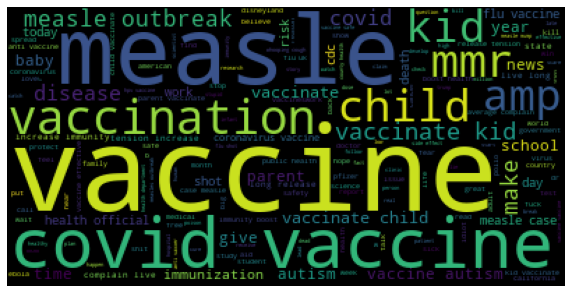

In [11]:
disp_wordcloud(training_set, 'tweet')

#### Check for imbalanced classes.

In [12]:
print(len(training_set[training_set.label == 0]))
print(len(training_set[training_set.label == 1]))
print(len(training_set[training_set.label == 2]))


7458
2073
6445


As we can see, the dataset is imbalanced, since the "Anti-Vax" class consists of way less samples than "Neutral" or "Pro-Vax" classes.

#### Have a look at the clean datasets.

In [13]:
training_set

,tweet,label
0,"[sip, shop, marjais, popularnobodie, mmr, marj...",0
1,"[I, family, I, covid, vaccine, anytime]",1
2,"[immunization, mandatory, period, oklahoma, wi...",2
3,"[president, obama, speak, favor, vaccination, ...",0
4,"[arizona, monitor, hundred, measle, link, disn...",0
...,...,...
15971,"[believe, anti, vax, nutcase, measle, ignore, ...",1
15972,"[feel, parent, vaccinate, kid, measlesoutbreak]",0
15973,"[preschooler, test, measle, simi, valley]",0
15974,"[finance, minister, budget, offer, room, procu...",0


In [14]:
val_set

,tweet,label
0,"[massive, surge, covid, death, immediately, va...",1
1,"[require, vaccine, school, parent, guardian, c...",0
2,"[johnson, county, child, measle]",0
3,"[nv, state, vaccinate, kid]",2
4,"[kill, w, fear, mt, vaccine, fear, fuel, resur...",2
...,...,...
2277,"[number, measle, case, report, cali, year, hig...",0
2278,"[evidence, point, idea, measles, affect, immun...",0
2279,"[vaccinate, kid, minute]",2
2280,"[favorite, autism, reason, bring, back, diseas...",2


## 3. Try to cure imbalanced sets

There are three (3) methods that have been tested in order to reduce the
class imbalance:

* Upsampling by duplicating samples in minor class.
* Downsampling by cutting down samples from the major classes.
* Upsampling by generating synthetic samples from the minor class.

### Let's try upsampling by duplicating the minor class.


In [ ]:
# Separate input features and target
y_train = training_set.label
X_train = training_set.drop('label', axis=1)

# Concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# Separate minority and majority classes
neutral = X[X.label==0]
antivax = X[X.label==1]
provax  = X[X.label==2]

# Upsample minority
antivax_upsampled = resample(antivax,
                            replace=True,
                            n_samples=(len(antivax) * 2 + 400),
                            random_state=27)

# Combine majority and upsampled minority
upsampled = pd.concat([neutral, antivax_upsampled, provax])

# Check new class counts
upsampled.label.value_counts()
training_set = upsampled

### Let's downsample the major classes.


In [ ]:
# Separate input features and target
y_train = training_set.label
X_train = training_set.drop('label', axis=1)

# Concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# Separate minority and majority classes
neutral = X[X.label==0]
antivax = X[X.label==1]
provax  = X[X.label==2]

# Downsample majority
neutral_downsampled = resample(neutral,
                            replace=False,
                            n_samples=len(antivax)*2 + 400,
                            random_state=27)

provax_downsampled = resample(provax,
                            replace=False, 
                            n_samples=len(antivax)*2 + 500, 
                            random_state=23) 

# Combine classes
downsampled = pd.concat([neutral_downsampled, antivax, provax_downsampled])

# Check new class counts
downsampled.label.value_counts()
training_set = downsampled

### Let's try upsampling by generating synthetic data.

In [ ]:
from imblearn.over_sampling import SMOTE
'''
Generate synthetic data, based on the input dictionary.
The dictionary contains the number of samples needed for 
each class, e.g:
        d = { 0: 7000, 
              1: 5000, 
              2: 6000 }
which means that class 0 must contain 7000 samples, class 1
must contain 5000 samples, etc.
'''
def synthetic_generation(X, y, dict_of_ratios, training_label, target_label):
    X = np.array(list(X.apply(lambda x: np.array(list(x)))))
    y = y.to_numpy()

    sm = SMOTE(dict_of_ratios)
    X, y = sm.fit_resample(X, y)

    for x in X:
        x = list(x)
    X = list(X)
    y = list(y)

    return pd.DataFrame({training_label: X, target_label: y})

## 4. Define Recurrent Neural Network models

In [15]:
'''
    Fully defines a Bidirectional RNN based on the given parameters.
    The RNN can support:
        - Stacked LSTM / GRU layers.
        - Gradient Clipping.
        - Skip Connections.
        - Attention.
'''
def define_RNN_model(input_size, hidden_size, num_layers, dropout=0.2, cell_type='LSTM', attention=True, skipconn=True, out_dim=3, grad_clip=True):
    parameters = {'input_size':input_size, 'hidden_size':hidden_size, 
                   'num_layers':num_layers, 'dropout':dropout, 
                   'bidirectional':True, 'batch_first':True}

    
    print(f'\nConstructing {cell_type.upper()} model with:\n')
    print(f'Number of stacked RNNs: {stacked_rnn_num}')
    print(f'Number of hidden features: {hidden_feature_num}')
    print(f'Dropout: {dropout}')
    if attention:
        print('Attention layer')
    if skipconn:
        print('Skip Connections')
    if grad_clip:
        print('Gradient Clipping\n')

    model = RNN(parameters, out_dim, cell_type, attention, skipconn, grad_clip) 
    model.cuda()
    return model

In [16]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
        # Define two (2) linear layers, in order to calculate attention
        self.fc1 = nn.Linear(self.hidden_size, self.hidden_size, bias=False)
        self.fc2 = nn.Linear(self.hidden_size*2, self.hidden_size, bias=False)

    def forward(self, hidden_states):
        # Calculate scores
        score1 = self.fc1(hidden_states)
        hs = hidden_states[:, -1, :]
        score = torch.bmm(score1, hs.unsqueeze(2)).squeeze(2)
        attention_weights = F.softmax(score, dim=1)
        context_vector = torch.bmm(hidden_states.permute(0, 2, 1), attention_weights.unsqueeze(2)).squeeze(2)
        pre_activation = torch.cat((context_vector, hs), dim=1)
        attention_vector = self.fc2(pre_activation)
        return torch.tanh(attention_vector)

In [17]:
# Simple Bidirectional LSTM/GRU model.
class RNN(nn.Module): 
    def __init__(self, params, output_dim, cell_type='lstm', apply_attention=True, skipconn=True, grad_clip=True):
        super(RNN, self).__init__()
        
        self.cell = cell_type.lower()

        self.skipconn = skipconn
        if self.cell == 'lstm':
            # Skip connections
            if skipconn == True:
                layers = [('LSTM0', nn.LSTM(input_size=params['input_size'], hidden_size=params['hidden_size'], num_layers=1, dropout=params['dropout'], bidirectional=True, batch_first=True))]
                for i in range(1, params['num_layers']):
                    layers.append(('LSTM' + str(i), nn.LSTM(input_size=params['hidden_size'], hidden_size=params['hidden_size'], num_layers=1, dropout=params['dropout'], bidirectional=True, batch_first=True)))
                self.rnn = nn.Sequential(OrderedDict( layers ))
            else:  
                self.rnn = nn.LSTM(**params)
        else:
            if skipconn == True:
                layers = [('GRU0', nn.GRU(input_size=params['input_size'], hidden_size=params['hidden_size'], num_layers=1, dropout=params['dropout'], bidirectional=True, batch_first=True))]
                for i in range(1, params['num_layers']):
                    layers.append(('GRU' + str(i), nn.GRU(input_size=params['hidden_size'], hidden_size=params['hidden_size'], num_layers=1, dropout=params['dropout'], bidirectional=True, batch_first=True)))
                self.rnn = nn.Sequential(OrderedDict( layers ))
            else:   
                self.rnn = nn.GRU(**params)

        if self.skipconn:
            # Number of hidden dimensions
            self.hidden_dim = self.rnn[0].hidden_size
            # Number of hidden layers
            self.num_layers = self.rnn[0].num_layers
        else:
            self.hidden_dim = self.rnn.hidden_size
            self.num_layers = self.rnn.num_layers

        self.grad_clip = grad_clip
        
        # Readout layer
        self.fc = nn.Linear(self.hidden_dim*2, output_dim)

        # Attention layer
        self.attention = False
        if apply_attention == True:
            self.attention = Attention(hidden_size=self.hidden_dim*2)

    def forward(self, x):
        # Set initial states
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_dim).to(device) # 2 for bidirection

        out = None
        if self.cell == 'lstm':
            c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_dim).to(device)

            if self.skipconn:
                out, _ = self.rnn[0](x, (h0, c0)) 
            else:    
                out, _ = self.rnn(x, (h0, c0)) 
        else:
            if self.skipconn:
                out, _ = self.rnn[0](x, h0)  
            else:    
                out, _ = self.rnn(x, h0)  

        if self.skipconn:
            for i in range(1, self.num_layers):
                identity = out.clone()
                output, _ = self.rnn[i](out)
                if i+1 < self.num_layers:
                    output, _ = self.rnn[i+1](output)
                out = output + identity

        if self.attention:
            return self.fc(self.attention(out))
        
        return self.fc(out[:, -1, :])

## 5. Define some utility functions

In [18]:
'''
    ROC curve plotting function
'''
def plot_roc_curve(y_test, y_score, num_classes):

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(num_classes):
        mean_tpr +=np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= num_classes

    lw = 2
    plt.figure()
    colors = cycle(["aqua", "darkorange", "cornflowerblue"])
    for i, color in zip(range(num_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for all classes")
    plt.legend(loc="lower right")
    plt.show()

In [19]:
'''
    Loss vs Epochs plotting function
'''
def loss_vs_epochs_loss(train_losses, valid_losses, num_epochs):
    plt.plot([i+1 for i in range(num_epochs)], train_losses, label = "Training loss")
    plt.plot([i+1 for i in range(num_epochs)], valid_losses, label = "Validation loss")
    plt.legend()
    plt.xlabel('Number of epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs Epochs Plot')
    plt.show()

In [30]:
'''
    Test a model with given parameters.
    The parameters are:
        - Training set
        - Validation set
        - A trainer
        - Number of epochs (opt.)
'''
def test_model_without_tuning(model, training_set, val_set, trainer, optimizer, num_epochs=10):
    train_df, test_df = training_set.copy(deep=True), val_set.copy(deep=True)
    # Shuffle the sets
    train_df = train_df.sample(frac=1).reset_index(drop=True)
    test_df = test_df.sample(frac=1).reset_index(drop=True)

    trainer.fit_train_test(train_df, test_df)

    loss_function = nn.CrossEntropyLoss()

    trainer.train(model, num_epochs, optimizer, loss_function)
    trainer.validate(model)

## 6. Word Embeddings Model

In [21]:
'''
    Word Embeddings model.
'''
class Embeddings_Trainer:

    def __init__(self, training_label, target_label, pre_trained_vectors, emb_dim=200):
        # Set up the device
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # Save the embeddings dimension and the pretrained vectors
        self.embeddings_dim = emb_dim
        self.pretrained_vectors = pre_trained_vectors
        # Save the training and target labels
        self.training_label = training_label
        self.target_label = target_label
        self.num_classes = 0

    def get_input_size(self):
        return self.embeddings_dim

    def get_num_classes(self):
        return self.num_classes

    # Function to make embeddings tensor to be used as input to network
    def make_word_emb_vector(self, sentence):        
        return torch.from_numpy(sentence.astype(np.float64)).to(self.device).view(1, sentence.shape[0], self.embeddings_dim).float()

    # Function to get the output tensor
    def make_tensor_target(self, label):
        return torch.tensor([label], dtype=torch.long, device=self.device)

    # Transforms the dataset into sequences of padded input vectors
    # based on a pretrained vector set
    def transform_dataset(self, df, pad):    

        def get_doc_vectors(sentence, pad): 

            def get_word_vectors(w):
                if w in self.pretrained_vectors:
                    return self.pretrained_vectors[w]
                else:
                    return self.pretrained_vectors['unk']

            encoded = np.zeros([pad, self.embeddings_dim], dtype=np.float64)
            enc1 = np.array([get_word_vectors(doc) for doc in sentence])
            length = min(pad, len(enc1))
            encoded[:length] = enc1[:length]
            return encoded

        df[self.training_label] = df[self.training_label].apply(lambda s: np.array(get_doc_vectors(s, pad)))
        return df

    def fit_train_test(self, train_df, test_df):

        self.num_classes = train_df[self.target_label].nunique()

        # Set the pad of the train and test sequences
        tr_sentence_lens = train_df[self.training_label].apply(lambda s: len(s)).to_numpy()
        test_sentence_lens = test_df[self.training_label].apply(lambda s: len(s)).to_numpy()
        tr_pad = 20
        test_pad = 20
        self.train_pad = tr_pad
        self.test_pad = test_pad

        self.train_df = self.transform_dataset(train_df, tr_pad)
        self.test_df = self.transform_dataset(test_df, test_pad)

    '''
        Main training function.
        
        Trains the input data by splitting them into 100
        batches.
        
        Plots the loss vs epochs diagram.
    '''
    def train(self, model, num_epochs, optimizer, loss_function):

        overall_train_loss = []
        overall_valid_loss = []
        # Training of the model.
        for epoch in range(num_epochs):
            train_loss = 0.0
            valid_loss = 0.0
            model.train()
            for batch in np.array_split(self.train_df, 100):
                for idx, (data, target) in batch.iterrows():
                
                    data = self.make_word_emb_vector(data).to(self.device)
                    target = self.make_tensor_target(target).to(self.device)

                    optimizer.zero_grad()
                    output = model(data)
                    loss = loss_function(output, target)
                    loss.backward()

                    # If Gradient Clipping is allowed
                    if model.grad_clip == True:
                        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=3.0, norm_type=2)

                    optimizer.step()

                    train_loss += loss.item()
                train_loss = train_loss / len(batch)
            overall_train_loss.append(train_loss)

            # Validation of the model.
            model.eval()
            with torch.no_grad():
                for idx, (data, target) in self.test_df.iterrows():

                    data = self.make_word_emb_vector(data).to(self.device)
                    target = self.make_tensor_target(target).to(self.device)
                    output = model(data)
                    loss = loss_function(output, target)

                    valid_loss += loss.item()

            valid_loss = valid_loss / len(self.test_df)
            overall_valid_loss.append(valid_loss)

            print(f"Epoch {epoch} : Train loss {str(train_loss)[:4]} | Valid loss {str(valid_loss)[:4]}")

        loss_vs_epochs_loss(overall_train_loss, overall_valid_loss, num_epochs)

    '''
        Validation mechanism.
        Prints classification report and a ROC curve.
    '''
    def validate(self, model):
        y_score = []
        y_test = []
        predictions = []
        original_labels = []
        with torch.no_grad():
            for idx, (data, target) in self.test_df.iterrows():    
                data = self.make_word_emb_vector(data).to(self.device)
                probs = model(data)

                y_score.append(probs.cpu().numpy().flatten())
                y_test.append(target)

                predictions.append(torch.argmax(probs, dim=1).cpu().numpy()[0])
                original_labels.append(self.make_tensor_target(target).cpu().numpy()[0])
        print(classification_report(original_labels, predictions))

        y_score = np.array(y_score)
        y_test = label_binarize(np.array(y_test), classes=[i for i in range(self.num_classes)] )
        plot_roc_curve(y_test, y_score, self.num_classes)

### Download GloVe's Tweeter dataset.

In [22]:
!wget https://nlp.stanford.edu/data/glove.twitter.27B.zip

--2022-09-22 17:55:40--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip [following]
--2022-09-22 17:55:40--  https://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [application/zip]
Saving to: ‘glove.twitter.27B.zip’

glove.twitter.27B.z 100%[===================>]   1.42G  5.06MB/s    in 4m 53s  

2022-09-22 18:00:33 (4.96 MB/s) - ‘glove.twitter.27B.zip’ saved [1520408563/1520408563]



In [23]:
!unzip -q glove.twitter.27B.zip
EMBEDDINGS_DIM = 200
pre_trained_vectors = {}
glove_embeddings_path = 'glove.twitter.27B.200d.txt'
f = open(glove_embeddings_path, encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    pre_trained_vectors[word] = coefs
f.close()

##7. Best Performing Models!

### 7.1 GRU Model

Based on all the testing, tuning and experimenting, the overall best per-
forming configuration for GRU is:
* 3 stacked GRU layers.
* 50 hidden features in each layer.
* Skip Connections.
* Gradient Clipping (max norm = 3).
* 0.5 dropout ratio.


Constructing GRU model with:

Number of stacked RNNs: 3
Number of hidden features: 50
Dropout: 0.5
Skip Connections
Gradient Clipping

Epoch 0 : Train loss 0.84 | Valid loss 0.72
Epoch 1 : Train loss 0.78 | Valid loss 0.75
Epoch 2 : Train loss 0.76 | Valid loss 0.82


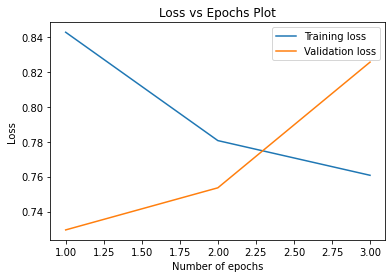

              precision    recall  f1-score   support

           0       0.83      0.70      0.76      1065
           1       0.55      0.34      0.42       296
           2       0.63      0.82      0.71       921

    accuracy                           0.70      2282
   macro avg       0.67      0.62      0.63      2282
weighted avg       0.71      0.70      0.70      2282



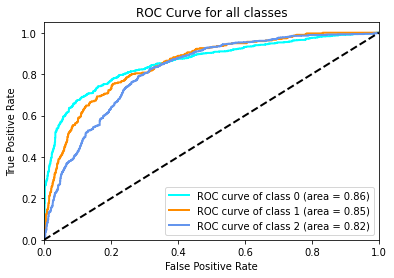

In [38]:
cell_type = 'gru'
stacked_rnn_num  = 3
dropout = 0.5
hidden_feature_num = 50
num_epochs = 3
attention = False
skipconn = True

trainer = Embeddings_Trainer('tweet', 'label', pre_trained_vectors, EMBEDDINGS_DIM)
model = define_RNN_model(EMBEDDINGS_DIM, hidden_feature_num, stacked_rnn_num, dropout, cell_type, attention, skipconn)

optimizer = optim.Adam(params=model.parameters(), lr=0.001)

test_model_without_tuning(model, training_set, val_set, trainer, optimizer, num_epochs)

###7.2 LSTM Model
Based on all the testing, tuning and experimenting, the overall best per-
forming configuration for LSTM is:
* 4 stacked LSTM layers.
* 50 hidden features in each layer.
* Skip Connections.
* Gradient Clipping (max norm = 3).
* 0.5 dropout ratio.


Constructing LSTM model with:

Number of stacked RNNs: 4
Number of hidden features: 50
Dropout: 0.5
Skip Connections
Gradient Clipping

Epoch 0 : Train loss 0.80 | Valid loss 0.72
Epoch 1 : Train loss 0.67 | Valid loss 0.71
Epoch 2 : Train loss 0.59 | Valid loss 0.75


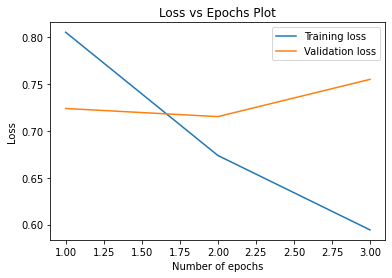

              precision    recall  f1-score   support

           0       0.81      0.76      0.78      1065
           1       0.55      0.39      0.46       296
           2       0.66      0.77      0.71       921

    accuracy                           0.72      2282
   macro avg       0.68      0.64      0.65      2282
weighted avg       0.72      0.72      0.71      2282



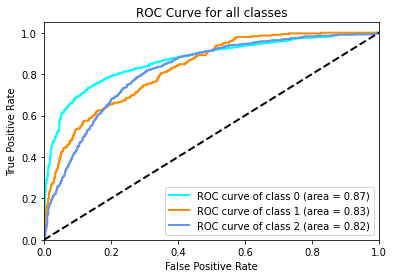

In [42]:
cell_type = 'lstm'
stacked_rnn_num  = 4
dropout = 0.5
hidden_feature_num = 50
num_epochs = 3
attention = False 
skipconn = True

trainer = Embeddings_Trainer('tweet', 'label', pre_trained_vectors, EMBEDDINGS_DIM)
model = define_RNN_model(EMBEDDINGS_DIM, hidden_feature_num, stacked_rnn_num, dropout, cell_type, attention, skipconn)

optimizer = optim.Adam(params=model.parameters(), lr=0.001)

test_model_without_tuning(model, training_set, val_set, trainer, optimizer, num_epochs)

##8. Adding Attention

### 8.1 GRU Model


Constructing GRU model with:

Number of stacked RNNs: 3
Number of hidden features: 50
Dropout: 0.5
Attention layer
Skip Connections
Gradient Clipping

Epoch 0 : Train loss 0.72 | Valid loss 0.83
Epoch 1 : Train loss 0.71 | Valid loss 0.86
Epoch 2 : Train loss 0.64 | Valid loss 1.02


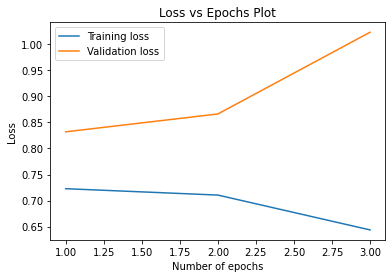

              precision    recall  f1-score   support

           0       0.82      0.69      0.75      1065
           1       0.39      0.47      0.42       296
           2       0.65      0.73      0.69       921

    accuracy                           0.68      2282
   macro avg       0.62      0.63      0.62      2282
weighted avg       0.70      0.68      0.68      2282



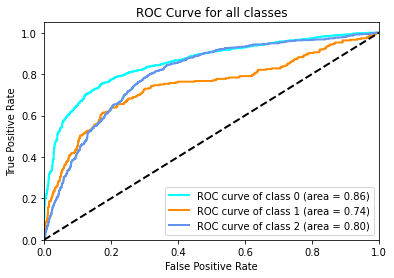

In [40]:
cell_type = 'gru'
stacked_rnn_num  = 3
dropout = 0.5
hidden_feature_num = 50
num_epochs = 3
attention = True
skipconn = True

trainer = Embeddings_Trainer('tweet', 'label', pre_trained_vectors, EMBEDDINGS_DIM)
model = define_RNN_model(EMBEDDINGS_DIM, hidden_feature_num, stacked_rnn_num, dropout, cell_type, attention, skipconn)

optimizer = optim.Adam(params=model.parameters())

test_model_without_tuning(model, training_set, val_set, trainer, optimizer, num_epochs)

###  8.2 LSTM Model


Constructing LSTM model with:

Number of stacked RNNs: 4
Number of hidden features: 50
Dropout: 0.5
Attention layer
Skip Connections
Gradient Clipping

Epoch 0 : Train loss 0.82 | Valid loss 0.72
Epoch 1 : Train loss 0.79 | Valid loss 0.77
Epoch 2 : Train loss 0.65 | Valid loss 0.94


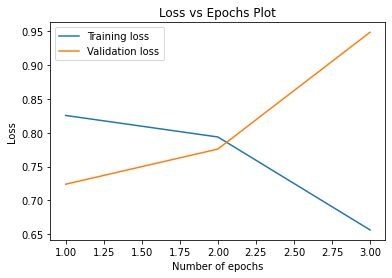

              precision    recall  f1-score   support

           0       0.84      0.70      0.76      1065
           1       0.49      0.42      0.45       296
           2       0.65      0.80      0.71       921

    accuracy                           0.70      2282
   macro avg       0.66      0.64      0.64      2282
weighted avg       0.71      0.70      0.70      2282



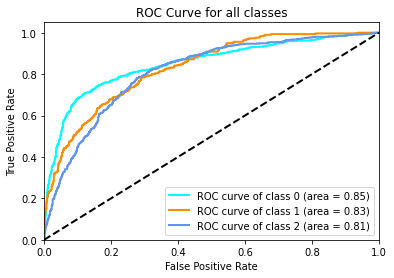

In [41]:
cell_type = 'lstm'
stacked_rnn_num  = 4
dropout = 0.5
hidden_feature_num = 50
num_epochs = 3
attention = True 
skipconn = True

trainer = Embeddings_Trainer('tweet', 'label', pre_trained_vectors, EMBEDDINGS_DIM)
model = define_RNN_model(EMBEDDINGS_DIM, hidden_feature_num, stacked_rnn_num, dropout, cell_type, attention, skipconn)

optimizer = optim.Adam(params=model.parameters())

test_model_without_tuning(model, training_set, val_set, trainer, optimizer, num_epochs)

## 9. Results
Based on all the testing, tuning and experimenting, the **overall best performing model** is a Word Embeddings LSTM model, consisting of:

* GloVe's pretrained 200-dimensional twitter vectors.
* 4 stacked LSTM layers.
* 50 hidden features in each layer.
* Skip Connections.
* Gradient Clipping (max norm = 3).
* **No** Attention mechanism.
* 0.5 dropout ratio
* Adam optimizer with learning rate=0.001.
* Cross Entropy loss function.
* 3 epochs of training.

The aforementioned model scored a weighted average f1-score of **71%**!

## 10. Experiment with **your** test set!

In [ ]:
training_set_path = r'YOUR TRAINING SET LINK GOES HERE'
test_set_path     = r'YOUR TEST SET LINK GOES HERE'

training_set = pd.read_csv(training_set_path, index_col=0)
test_set = pd.read_csv(test_set_path, index_col=0)

**WARNING**: In order for this section to work, you'll have to fully execute sections:

* 1 (Imports and initializations *without linking Google Drive*)
* 2 (Preprocessing)
* 4 (Define Recurrent Neural Network models)
* 5 (Define some utility functions)
* 6 (Word Embeddings Model)

In [ ]:
# Run this code cell!
cell_type = 'lstm'
stacked_rnn_num  = 4
dropout = 0.5
hidden_feature_num = 50
num_epochs = 3
attention = False 
skipconn = True

trainer = Embeddings_Trainer('tweet', 'label', pre_trained_vectors, EMBEDDINGS_DIM)
model = define_RNN_model(EMBEDDINGS_DIM, hidden_feature_num, stacked_rnn_num, dropout, cell_type, attention, skipconn)

optimizer = optim.Adam(params=model.parameters(), lr=0.001)

test_model_without_tuning(model, training_set, val_set, trainer, optimizer, num_epochs)

## 11. Sources 

* [Deal With Imbalanced Data](https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18)

* [Pytorch Manual](https://pytorch.org/)

* [General Info]({https://www.analyticsvidhya.com/})